In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm 
import random
import arviz as az

C:\Users\boypa\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
game_df = pd.read_csv('C:/Users/boypa/OneDrive - The University of Auckland/ML Project/ABTest/cookie_cats.csv')

## Data Exploration

In [3]:
game_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
game_df[['version','retention_1' ,'retention_7','sum_gamerounds']].groupby('version').mean()

,retention_1,retention_7,sum_gamerounds
version,,,
gate_30,0.448188,0.190201,52.456264
gate_40,0.442283,0.182000,51.298776


gate_30         Axes(0.1,0.15;0.363636x0.75)
gate_40    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

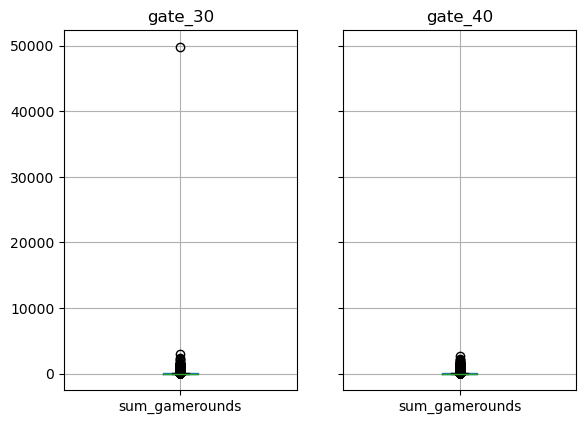

In [6]:
game_df[['version','sum_gamerounds']].groupby('version').boxplot()

In [7]:
game_df[['version','sum_gamerounds']].groupby('version').describe()

sum_gamerounds                                                      
                 count       mean         std  min  25%   50%   75%      max
version                                                                     
gate_30        44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0

## Bayesian A/B Test Hierarchical Model : retention_1

In [8]:
n_sample = 1000
control_data, treatment_data = game_df[game_df['version']=='gate_30']['retention_1'].reset_index(drop=True), game_df[game_df['version']=='gate_40']['retention_1'].reset_index(drop=True)
control_data,treatment_data = control_data.iloc[list(np.random.randint(1,len(control_data),n_sample))],treatment_data.iloc[list(np.random.randint(1,len(treatment_data),n_sample))]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, p_control, p_treatment]


Output()

Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 186 seconds.


array([[<Axes: title={'center': 'p_control'}>,
        <Axes: title={'center': 'p_treatment'}>,
        <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'p_control_bounded'}>,
        <Axes: title={'center': 'p_treatment_bounded'}>],
       [<Axes: title={'center': 'delta_p'}>, <Axes: >, <Axes: >]],
      dtype=object)

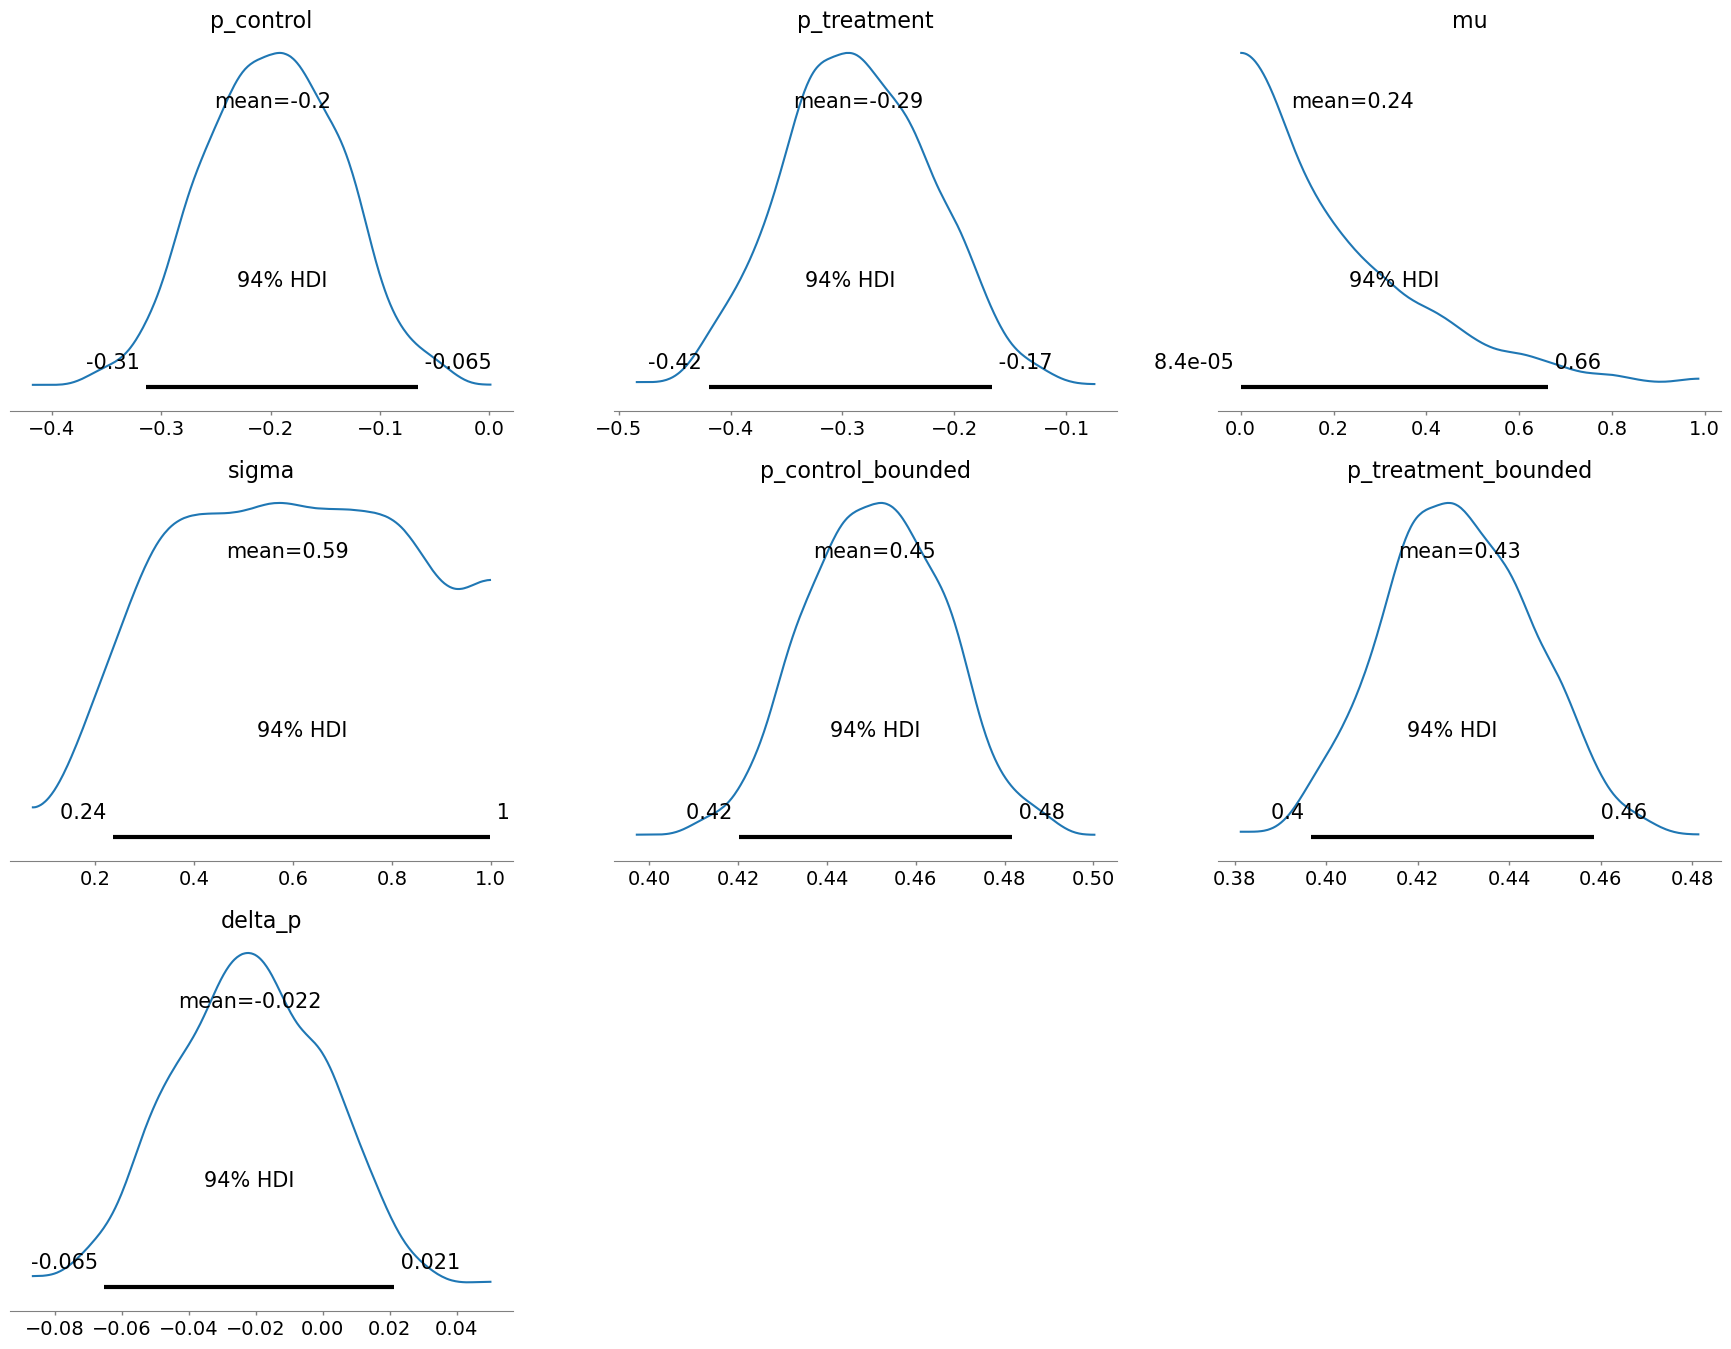

In [9]:


with pm.Model() as hierarchical_model:
    # Hyperpriors for the group-level distributions
    mu = pm.Uniform('mu', lower=0, upper=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)

    # Group-level priors for control and treatment
    p_control = pm.Normal('p_control', mu=mu, sigma=sigma)
    p_treatment = pm.Normal('p_treatment', mu=mu, sigma=sigma)

    # Ensure p_control and p_treatment are bounded between 0 and 1
    p_control = pm.Deterministic('p_control_bounded', pm.math.sigmoid(p_control))
    p_treatment = pm.Deterministic('p_treatment_bounded', pm.math.sigmoid(p_treatment))

    # Likelihood for control group
    control_likelihood = pm.Bernoulli('control', p=p_control, observed=control_data)
    
    # Likelihood for treatment group
    treatment_likelihood = pm.Bernoulli('treatment', p=p_treatment, observed=treatment_data)

    # Calculate delta_p
    delta_p = pm.Deterministic('delta_p', p_treatment - p_control)

    # Sampling from the posterior distribution
    trace = pm.sample(500, tune=200, return_inferencedata=False, target_accept=0.9)
    trace_idata = pm.to_inference_data(trace)

# Plotting the Posterior Distributions
az.summary(trace_idata)
az.plot_posterior(trace_idata)
